# Dados da COVID-19 no Estado do Rio de Janeiro

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np

dados = pd.read_csv('C:/Users/Annie/Pictures/060720/dadocaso1.csv')
dados.data = pd.to_datetime(dados.data) #Transformou o dado em data
dados.set_index('data',inplace = True) #Tornou a data como índice
dados.head()

,casos
data,
2020-02-15,4
2020-02-16,1
2020-02-17,4
2020-02-18,3
2020-02-19,6


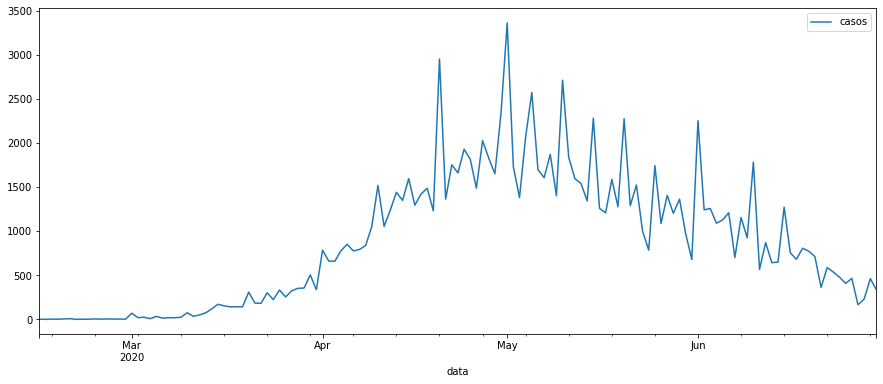

In [2]:
dados.plot(figsize = (15,6)) 

# Analisar a Tendência

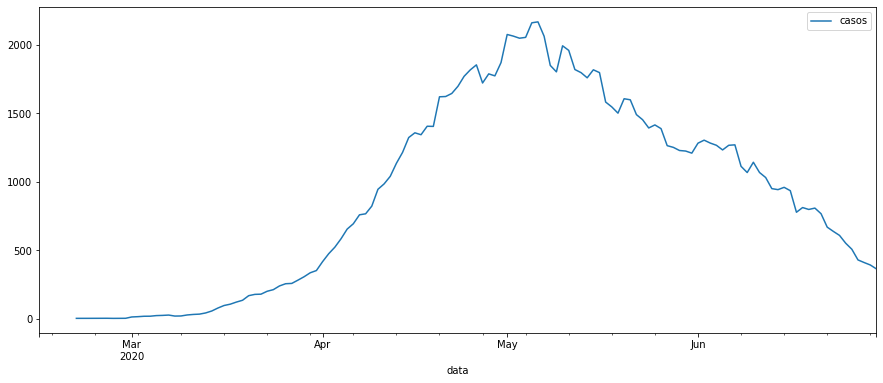

In [3]:
dados.rolling(7).mean().plot(figsize = (15,6)) #Período de 7 por ser dia da semana

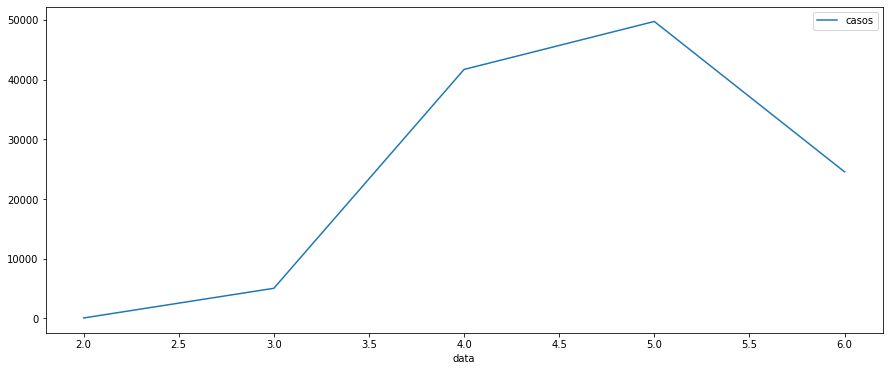

In [4]:
dados.groupby(dados.index.month).sum().plot(figsize = (15,6)) #Agrupando por mês

# Sazonalidade

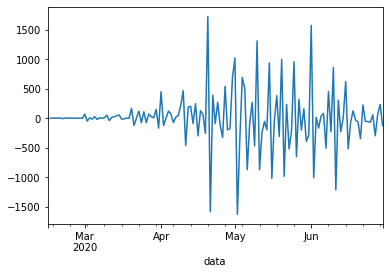

In [5]:
dados.casos.diff() #Diferença da quantidade do dia anterior
dados.casos.diff().plot()

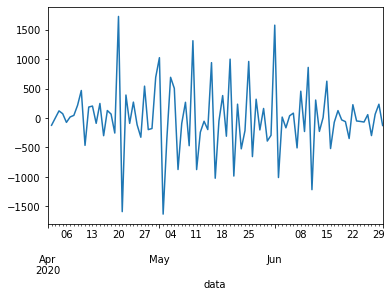

In [6]:
filtro = (dados.index.month >= 4) #Filtro de abril em diante
dados[filtro].casos.diff().plot() #Analisar os picos

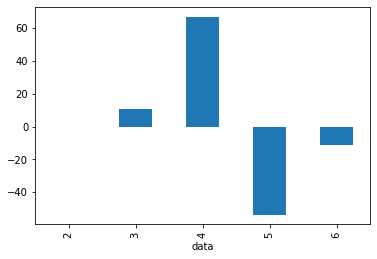

In [7]:
dados.casos.groupby(dados.index.month).mean()
dados.casos.diff().groupby(dados.index.month).mean().plot(kind = 'bar') # dos meses

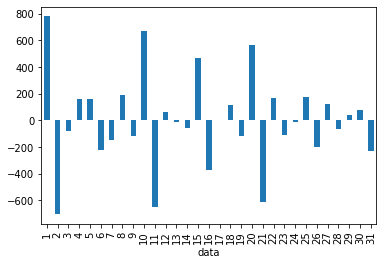

In [8]:
dados.casos.diff().groupby(dados.index.day).mean().plot(kind = 'bar') #Dias

# Modelo Preditivo:
# Modelo Naive

In [9]:
dados['naive'] = dados.casos.shift(1) #Modelo básico usa como previsão o dado do dia anterior
dados.head()

,casos,naive
data,,
2020-02-15,4,NaN
2020-02-16,1,4.0
2020-02-17,4,1.0
2020-02-18,3,4.0
2020-02-19,6,3.0


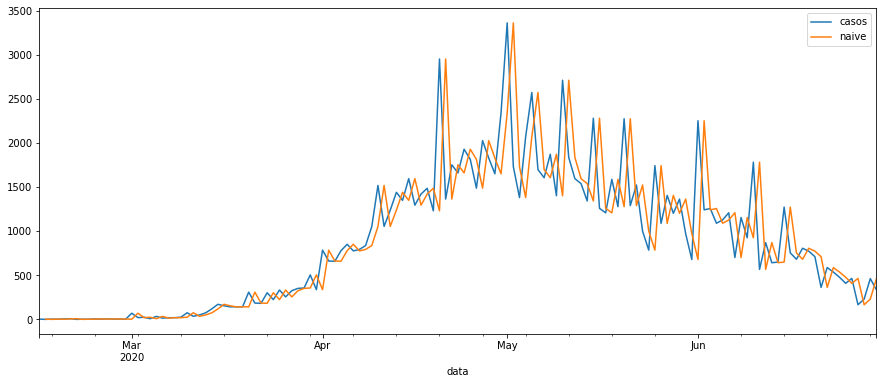

In [10]:
dados.plot(figsize = (15,6))

In [11]:
import numpy as np #MAPE 

def mean_absolute_percentage_error(y_true, y_pred): 
    # y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) /(y_true))) * 100

mean_absolute_percentage_error(dados.casos, dados.naive)

44.92978929343644

In [12]:
((dados.casos - dados.naive)**2).mean() #Calculo do erro médio ao quadrado 

219343.58823529413

# Modelo AutoRegressor (AR)

# Lag = 1

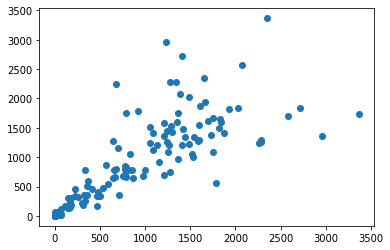

In [13]:
dados['x1']= dados.casos.shift(1) # Caso anterio = 1
dados.dropna(axis = 0, inplace = True) #Removendo as linhas nulas, pois o modelo não aceita
plt.scatter(dados.x1, dados.casos) #Gráfico de dispersão, para verificar se são lineares

In [14]:
#Com LAG = 1
from sklearn.linear_model import LinearRegression
X = dados.x1.values #Transformando em vetor 
y = dados.casos.values #Transformando em vetor
regressao = LinearRegression().fit(X.reshape(-1,1),y)
previsoes = regressao.predict(X.reshape(-1,1))
((y - previsoes)**2).mean() #Calculando o erro

197184.42322952137

Text(0, 0.5, 'Casos')

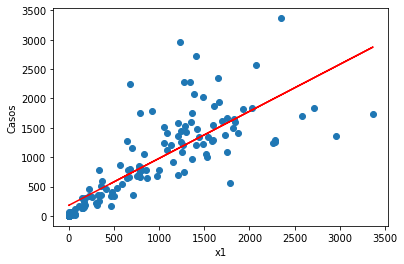

In [15]:
plt.scatter(X,y)
plt.plot(X, previsoes, color='red')
plt.xlabel('x1')
plt.ylabel('Casos')

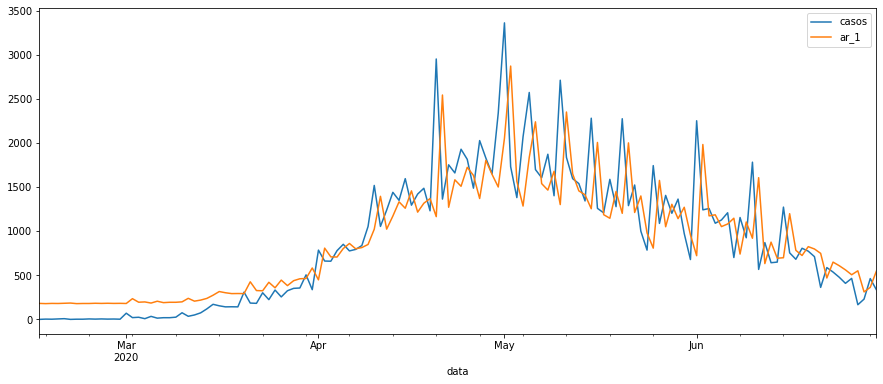

In [16]:
dados['ar_1']= previsoes
dados[['casos','ar_1']].plot(figsize = (15,6))

# Lag = 2

In [17]:
from statsmodels.tsa.ar_model import AR #O mesmo processo mais acelerado
ar_2 = AR(dados.casos, freq = 'D').fit(2) #Frequência de dias 
((ar_2.resid)**2).mean()

C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


156322.76070097103

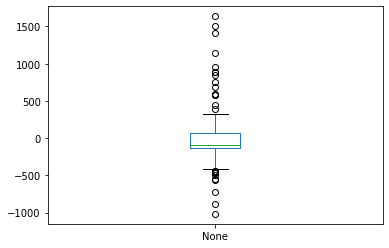

In [18]:
ar_2.resid.plot(kind = 'box') #boxplot. Analisando a distribuição do erro

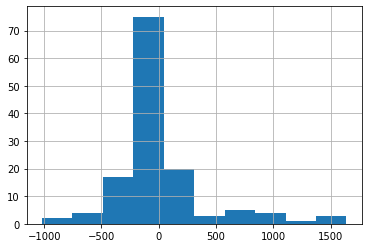

In [19]:
ar_2.resid.hist() #Analisando a distribuição do erro

# Lag = 3

In [20]:
from statsmodels.tsa.ar_model import AR #O mesmo processo mais acelerado
ar_3 = AR(dados.casos, freq = 'D').fit(3) #Frequência de dias 
((ar_3.resid)**2).mean()

C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


139016.6028208457

In [21]:
ar_3.predict(start = '2020-07-01', end = '2020-07-01') #Previsão de um dia

2020-07-01    391.166519
Freq: D, dtype: float64

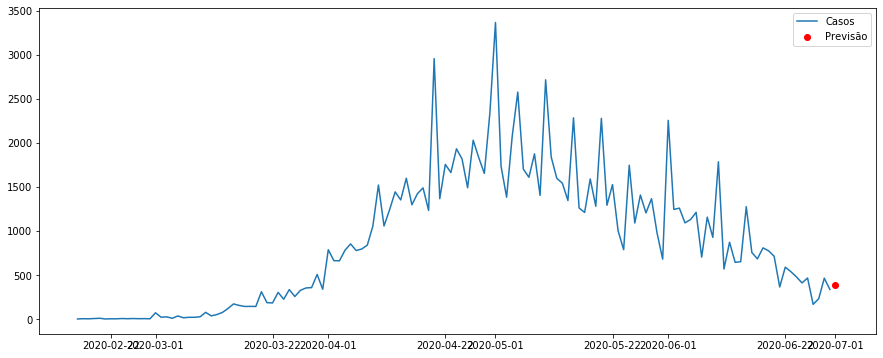

In [22]:
plt.figure(figsize = (15,6))
plt.plot(dados.casos)
forecast = ar_3.predict(start = '2020-07-01', end = '2020-07-01')
plt.scatter(forecast.index, forecast.values, color = 'red')
plt.legend(['Casos','Previsão'])

# Autocorrelação Total e Parcial

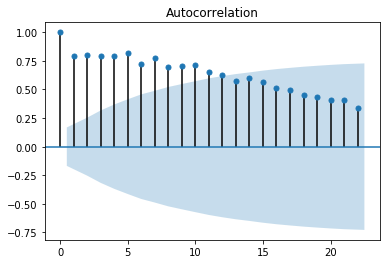

In [23]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(dados.casos) #Total
plt.show()

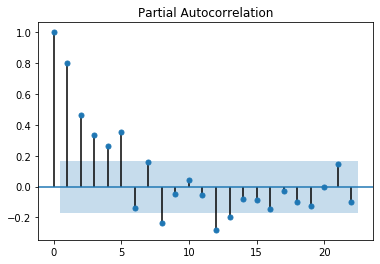

In [24]:
plot_pacf(dados.casos) #Parcial
plt.show()

# Validação Train/Test

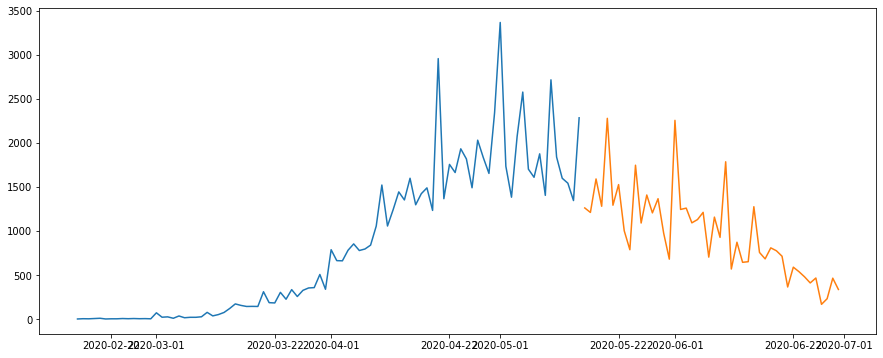

In [25]:
train_size = int(len(dados.casos)*2/3)
train_set = dados.casos[:train_size] #Dados para treino
test_set = dados.casos[train_size:] #Dados para teste
plt.figure(figsize = (15,6))
plt.plot(train_set)
plt.plot(test_set)

C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


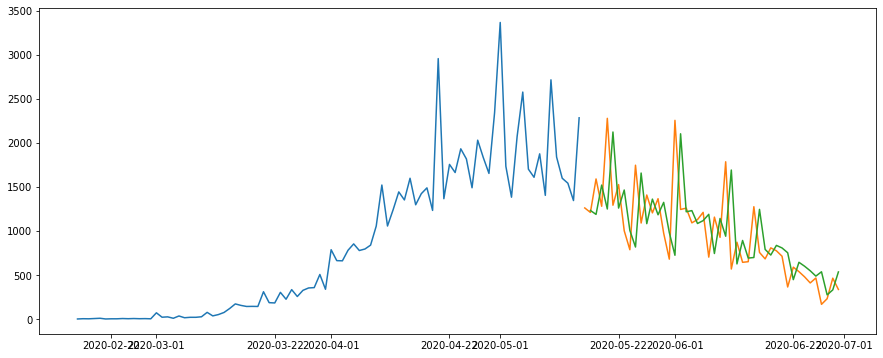

In [26]:
from statsmodels.tsa.ar_model import AR
ar_1 = AR(train_set, freq = 'D').fit(1)
#Função com lag = 1
previsao_1 = ar_1.params[0] + ar_1.params[1]*test_set.shift(1) 
plt.figure(figsize = (15,6))
plt.plot(train_set)
plt.plot(test_set)
plt.plot(previsao_1) #Verde

In [27]:
mean_absolute_percentage_error(test_set, previsao_1)

39.80812989836562

C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


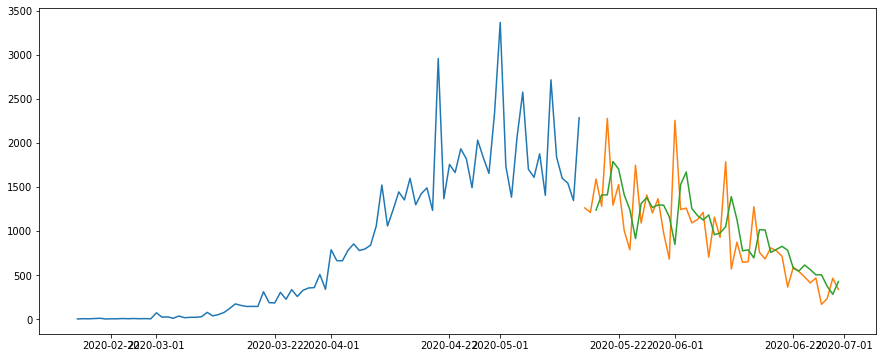

In [28]:
#Com t-2
from statsmodels.tsa.ar_model import AR
ar_2 = AR(train_set, freq = 'D').fit(2)
#Função com lag = 2 
previsao_2 = ar_2.params[0] + ar_2.params[1]*test_set.shift(1) +  ar_2.params[2]*test_set.shift(2)
plt.figure(figsize = (15,6))
plt.plot(train_set)
plt.plot(test_set)
plt.plot(previsao_2) #Verde

In [29]:
mean_absolute_percentage_error(test_set, previsao_2)

35.54425803631674

C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


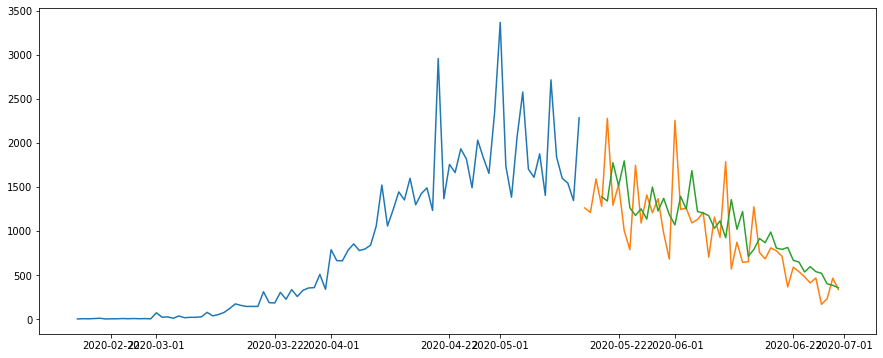

In [30]:
#Com t-3
from statsmodels.tsa.ar_model import AR
ar_3 = AR(train_set, freq = 'D').fit(3)
#Função com lag = 3
previsao_3 = ar_3.params[0]
for i, coef in enumerate(ar_3.params[1:]):
    previsao_3 += coef * test_set.shift(i + 1)
#Gráfico
plt.figure(figsize = (15,6))
plt.plot(train_set)
plt.plot(test_set)
plt.plot(previsao_3) #Verde, sem 3 dias divido ao modelo  

In [31]:
mean_absolute_percentage_error(test_set, previsao_3)

37.94425667480263

C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


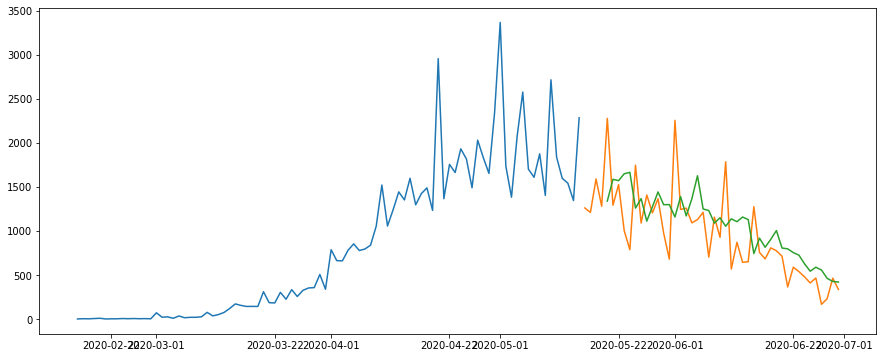

In [32]:
# com t-4
from statsmodels.tsa.ar_model import AR
ar_4 = AR(train_set, freq = 'D').fit(4)
#função com lag = 4
previsao_4 = ar_4.params[0]
for i, coef in enumerate(ar_4.params[1:]):
    previsao_4 += coef * test_set.shift(i + 1)
#gráfico
plt.figure(figsize = (15,6))
plt.plot(train_set)
plt.plot(test_set)
plt.plot(previsao_4) #verde, sem 4 dias divido ao modelo   

In [33]:
mean_absolute_percentage_error(test_set, previsao_4)

42.711331361414906

C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


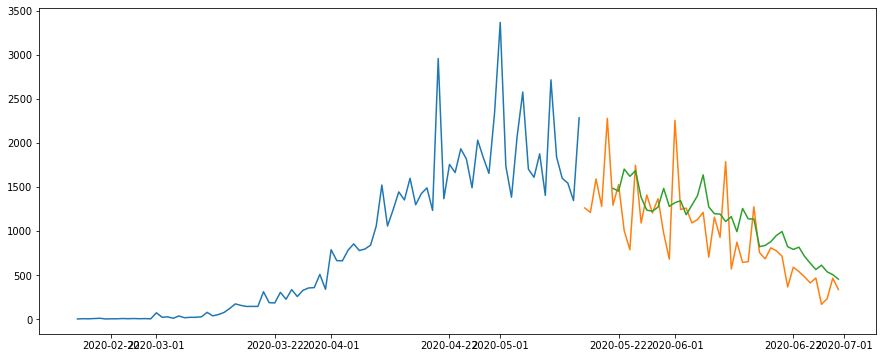

In [34]:
# com t-5
from statsmodels.tsa.ar_model import AR
ar_5 = AR(train_set, freq = 'D').fit(5)
#função com lag = 5
previsao_5 = ar_5.params[0]
for i, coef in enumerate(ar_5.params[1:]):
    previsao_5 += coef * test_set.shift(i + 1)
#gráfico
plt.figure(figsize = (15,6))
plt.plot(train_set)
plt.plot(test_set)
plt.plot(previsao_5) #verde, sem 5 dias divido ao modelo   

In [35]:
mean_absolute_percentage_error(test_set, previsao_5)

45.06415598334368

C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


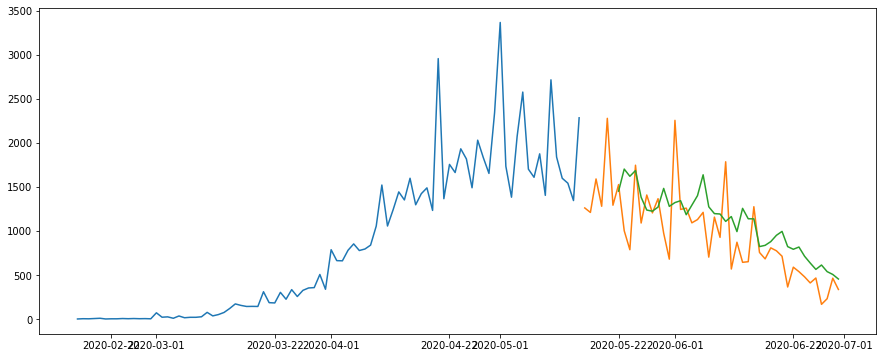

In [36]:
# com t-6
from statsmodels.tsa.ar_model import AR
ar_6 = AR(train_set, freq = 'D').fit(6)
#função com lag = 6
previsao_6 = ar_6.params[0]
for i, coef in enumerate(ar_6.params[1:]):
    previsao_6 += coef * test_set.shift(i + 1)
#gráfico
plt.figure(figsize = (15,6))
plt.plot(train_set)
plt.plot(test_set)
plt.plot(previsao_6) #verde, sem 6 dias divido ao modelo 


In [37]:
mean_absolute_percentage_error(test_set, previsao_6)

45.98444779266938

C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


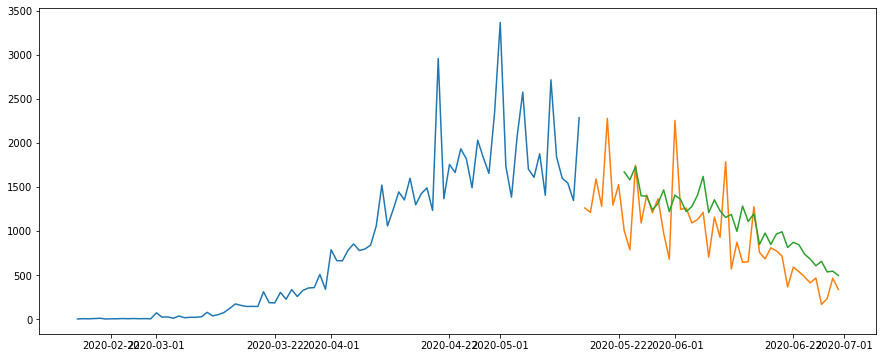

In [38]:
# com t-7
from statsmodels.tsa.ar_model import AR
ar_7 = AR(train_set, freq = 'D').fit(7)
#função com lag = 7
previsao_7 = ar_7.params[0]
for i, coef in enumerate(ar_7.params[1:]):
    previsao_7 += coef * test_set.shift(i + 1)
#gráfico
plt.figure(figsize = (15,6))
plt.plot(train_set)
plt.plot(test_set)
plt.plot(previsao_7) #verde, sem 7 dias divido ao modelo  

In [39]:
mean_absolute_percentage_error(test_set, previsao_7)

48.816804964949924

# Modelo AutoRegrssivo de Médias Moveis (ARMA)

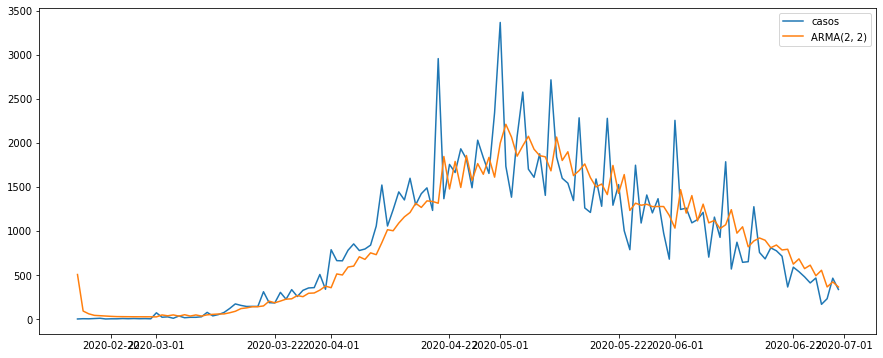

In [40]:
from statsmodels.tsa.arima_model import ARMA
arma = ARMA(dados.casos, freq = 'D', order = (2,2)).fit()
plt.figure(figsize = (15,6))
plt.plot(dados.casos)
plt.plot(arma.predict())
plt.legend(['casos', 'ARMA(2, 2)'])

In [41]:
#Para validar (1,1)
n = len(dados.casos)
train_size = int(n*2/3)
train_set = dados.casos[:train_size]
test_set = dados.casos[train_size:]
arma11_train = ARMA(train_set, freq = 'D', order = (1,1)).fit()
arma11_train.params
arma11_test = ARMA(test_set, freq = 'D', order = (1,1)).fit(arma11_train.params)
np.mean(np.abs((arma11_test.resid) /(test_set))) * 100

37.077117214425435

In [42]:
#Para validar (1,2)
n = len(dados.casos)
train_size = int(n*2/3)
train_set = dados.casos[:train_size]
test_set = dados.casos[train_size:]
arma12_train = ARMA(train_set, freq = 'D', order = (1,2)).fit()
arma12_train.params
arma12_test = ARMA(test_set, freq = 'D', order = (1,2)).fit(arma12_train.params)
(arma12_test.resid ** 2).mean()
np.mean(np.abs((arma12_test.resid) /(test_set))) * 100

35.94884876311035

In [43]:
#Executar teste de combinações
n = len(dados.casos)
train_size = int(n*2/3)
train_set = dados.casos[:train_size]
test_set = dados.casos[train_size:]
configs = [(1,1),(1,2),(1,3),(1,4),(1,6),(3,0),(3,1),(2,0),(2,1),(4,0),(4,1),(5,0),(5,1),(5,2)] #Os testes que não geraram erro
best = 100000
for config in configs:
    arma = ARMA(train_set, freq = 'D', order = config).fit()
    arma_test = ARMA(test_set,freq = 'D', order = config).fit(arma.params)
    erro = np.mean(np.abs((arma_test.resid) /(test_set))) * 100

    print(config,erro) 

(1, 1) 37.077117214425435
(1, 2) 35.94884876311035
(1, 3) 36.010943905222526
(1, 4) 34.34349775276726
(1, 6) 31.969649509308535
(3, 0) 35.173831177009305
(3, 1) 35.9213454334717
(2, 0) 35.92884914175607
(2, 1) 35.93585256082949
(4, 0) 34.94948359138318
(4, 1) 35.96757898000207
(5, 0) 34.12234505410786
(5, 1) 32.973799959443454
(5, 2) 33.58539227666303


# Modelo Integrado AutoRegressivo de Média Móveis (ARIMA)

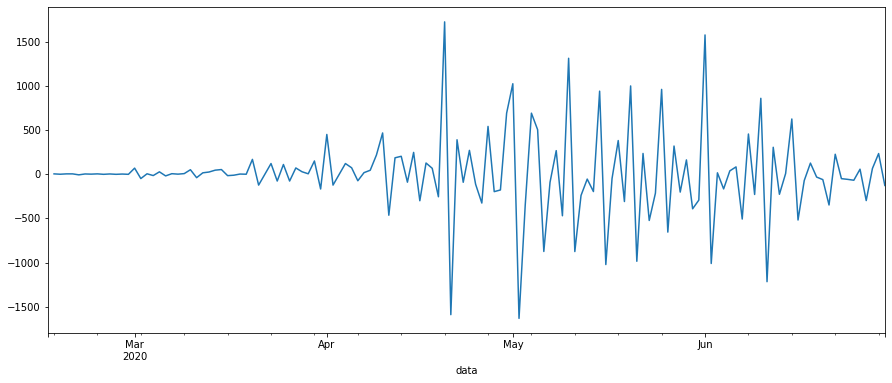

In [44]:
dados.casos.diff().plot(figsize=(15,6))

In [45]:
from statsmodels.tsa.arima_model import ARIMA
arima = ARIMA(dados.casos, freq='D', order=(1,1,2)).fit()
(arima.resid**2).mean() #Erro médio ao quadrado

124617.58710957252

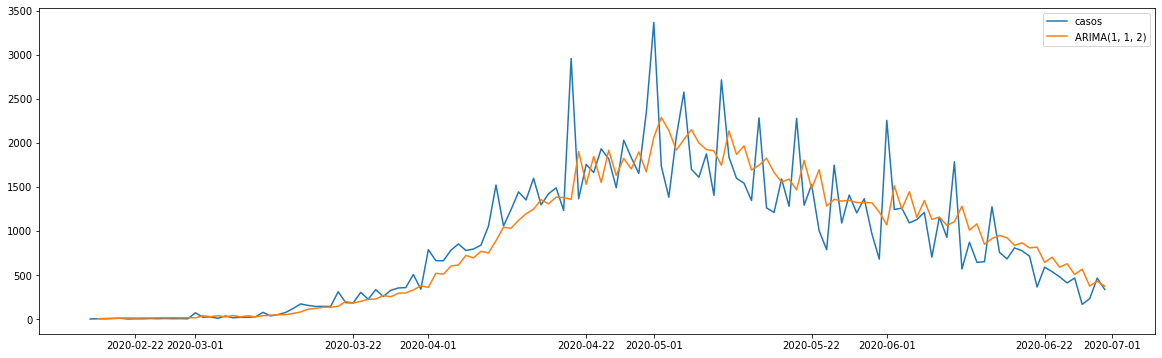

In [46]:
plt.figure(figsize=(20, 6))
plt.plot(dados.casos)
plt.plot(arima.predict(typ='levels')) #typ é usado para reverter o diff
plt.legend(['casos', 'ARIMA(1, 1, 2)'])

In [47]:
arima.forecast()[0]

array([422.71027395])

In [48]:
orders = [(1,1,1),(1,1,2),(1,2,2),(2,1,1),(2,2,1),(2,1,2),(2,2,2),(3,1,1),(3,1,2),(3,2,2),(3,2,1),(3,2,3),(3,1,3),(3,3,3),(4,2,2),(5,2,3),(4,1,1),(5,1,1),(6,1,1)]
best = 10000
for order in orders:
    try:
        model_train = ARIMA(train_set, freq='D', order=order).fit()
        model_test = ARIMA(test_set, freq='D', order=order).fit(model_train.params)
        erro = np.mean(np.abs((model_test.resid) /(test_set))) * 100 #MAPE
        print(f'ARIMA{order} = {erro}')

    except:
        pass

ARIMA(1, 1, 1) = 27.506579261455155


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(1, 1, 2) = 27.22062289869686
ARIMA(2, 1, 1) = 27.46198918634323


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


ARIMA(3, 1, 1) = 27.992268476666172
ARIMA(3, 2, 1) = 32.25477102452326


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(3, 2, 3) = 31.101457794803732


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(4, 2, 2) = 29.65408899902455


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(5, 2, 3) = 28.987993950340137
ARIMA(4, 1, 1) = 28.468741907096373


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packag

ARIMA(5, 1, 1) = 29.405325454863295
ARIMA(6, 1, 1) = 29.28765788327709


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [73]:
#O MELHOR RESULTADO
model_train = ARIMA(train_set, freq='D', order=(1,1,2)).fit()
model_test = ARIMA(test_set, freq='D', order=(1,1,2)).fit(model_train.params)
erro = np.mean(np.abs((model_test.resid ) /(test_set))) * 100

C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [74]:
model_test.predict(typ='levels',start='2020-07-01', end='2020-07-01')

2020-07-01    188.17207
Freq: D, dtype: float64

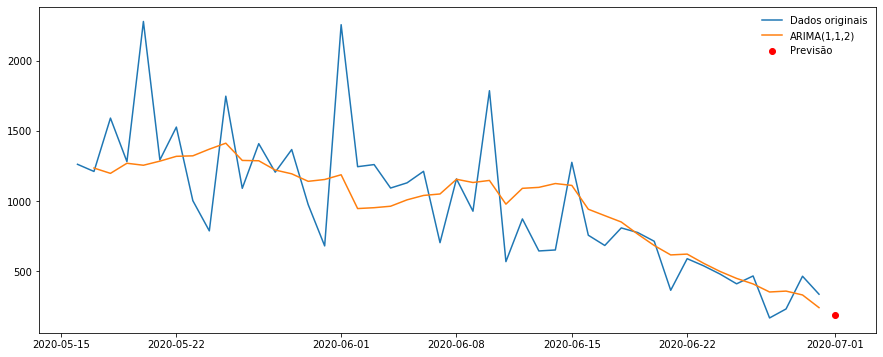

In [76]:
plt.figure(figsize=(15, 6))
plt.plot(test_set)
plt.plot(model_test.predict(typ='levels'))
forecast = model_test.predict(typ='levels',start='2020-07-01', end='2020-07-01')
plt.scatter(forecast.index, forecast.values, color='red')
plt.legend(['Dados originais','ARIMA(1,1,2)', 'Previsão'], frameon=False)

# Modelo AutoRegressivo Sazonal de Média Móveis Integrado (SARIMA)

data
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
5    AxesSubplot(0.125,0.125;0.775x0.755)
6    AxesSubplot(0.125,0.125;0.775x0.755)
Name: casos, dtype: object

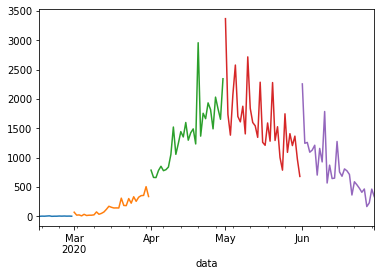

In [49]:
dados.casos.groupby(dados.index.month).plot() #Cada mês

In [50]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima = SARIMAX(dados.casos, freq='D', order=(2, 1, 2), seasonal_order=(3, 1, 2, 12)).fit()
(sarima.resid ** 2).mean()

C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


111279.20962124516

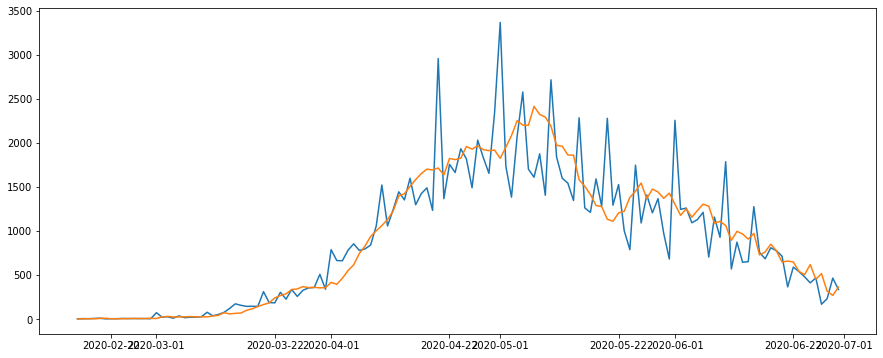

In [51]:
plt.figure(figsize=(15, 6))
plt.plot(dados.casos)
plt.plot(sarima.predict(typ='levels'))

In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
orders = [(1,1,1,12),(1,1,2,12),(1,2,2,12),(2,1,1,12),(2,2,1,12),(2,1,2,12),(2,2,2,12),(3,1,1,12),(3,1,2,12),(3,2,2,12),(3,2,1,12),(3,2,3,12),(3,1,3,12),(3,3,3,12),(4,2,2,12),(5,2,3,12)]
best = 10000
for order in orders:
    try:
        model_train = SARIMAX(train_set, freq='D', order=(1, 1, 2), seasonal_order= order).fit()
        model_test = SARIMAX(test_set, freq='D', order=(1, 1, 2), seasonal_order= order).fit(model_train.params)
        erro = np.mean(np.abs((model_test.resid) /(test_set))) * 100 #MAPE
        print(f'SARIMA{order} = {erro}')

    except:
        pass

C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 1, 12) = 47.38419944802707


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 2, 12) = 47.74888837185522


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimiz

SARIMA(1, 2, 2, 12) = 60.613496390824615


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge

SARIMA(2, 1, 1, 12) = 48.180680563595764


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(2, 2, 1, 12) = 63.42253490078933


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(2, 1, 2, 12) = 47.73639141951551


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(2, 2, 2, 12) = 57.672137255346136


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(3, 1, 1, 12) = 47.36363834106054


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(3, 1, 2, 12) = 48.216394919482276


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(3, 2, 2, 12) = 62.402579565735586


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(3, 2, 1, 12) = 61.96283942931504


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(3, 2, 3, 12) = 57.764072841231005


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(3, 1, 3, 12) = 47.75057539528073


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(3, 3, 3, 12) = 101.25201375266212


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(4, 2, 2, 12) = 62.00521988774048


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(5, 2, 3, 12) = 60.95043983050859


In [53]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
orders = [(1,1,1,12),(1,1,2,12),(1,2,2,12),(2,1,1,12),(2,2,1,12),(2,1,2,12),(2,2,2,12),(3,1,1,12),(3,1,2,12),(3,2,2,12),(3,2,1,12),(3,2,3,12),(3,1,3,12),(3,3,3,12),(4,2,2,12),(5,2,3,12)]
best = 10000
for order in orders:
    try:
        model_train = SARIMAX(train_set, freq='D', order=(3, 1, 1), seasonal_order= order).fit()
        model_test = SARIMAX(test_set, freq='D', order=(3, 1, 1), seasonal_order= order).fit(model_train.params)
        erro = np.mean(np.abs((model_test.resid) /(test_set))) * 100 #MAPE
        print(f'SARIMA{order} = {erro}')
    except:
        pass

C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 1, 12) = 48.53362412365566


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 2, 12) = 48.61927345166768


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(1, 2, 2, 12) = 57.90130228233028


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(2, 1, 1, 12) = 46.70303408972261


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(2, 2, 1, 12) = 64.00241121114594


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(2, 1, 2, 12) = 46.37366845159004


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(2, 2, 2, 12) = 58.21003190744358


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(3, 1, 1, 12) = 45.9243383977906


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(3, 1, 2, 12) = 46.424135705209544


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(3, 2, 2, 12) = 62.34123421921577


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(3, 2, 1, 12) = 59.39050057370176


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(3, 2, 3, 12) = 59.824142479113426


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(3, 1, 3, 12) = 46.415484218185206


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(3, 3, 3, 12) = 102.0606042563235


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(4, 2, 2, 12) = 59.327697885383465


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(5, 2, 3, 12) = 59.569282277046334


In [54]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
orders = [(1,1,1,12),(1,1,2,12),(1,2,2,12),(2,1,1,12),(2,2,1,12),(2,1,2,12),(2,2,2,12),(3,1,1,12),(3,1,2,12),(3,2,2,12),(3,2,1,12),(3,2,3,12),(3,1,3,12),(3,3,3,12),(4,2,2,12),(5,2,3,12)]
best = 10000
for order in orders:
    try:
        model_train = SARIMAX(train_set, freq='D', order=(2, 1, 1), seasonal_order= order).fit()
        model_test = SARIMAX(test_set, freq='D', order=(2, 1, 1), seasonal_order= order).fit(model_train.params)
        erro = np.mean(np.abs((model_test.resid) /(test_set))) * 100 #MAPE
        print(f'SARIMA{order} = {erro}')

    except:
        pass

C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 1, 12) = 47.40325022377707


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(1, 1, 2, 12) = 46.70551016664458


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(1, 2, 2, 12) = 60.08839635752318


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(2, 1, 1, 12) = 46.61980268529046


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(2, 2, 1, 12) = 67.3415855946925


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(2, 1, 2, 12) = 46.239280308849466


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(2, 2, 2, 12) = 61.14082194564758


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(3, 1, 1, 12) = 45.90771069634699


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(3, 1, 2, 12) = 46.55436323268841


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(3, 2, 2, 12) = 65.16598007027957


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", 

SARIMA(3, 2, 3, 12) = 60.977964273751375


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(3, 1, 3, 12) = 46.24027903372639


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(3, 3, 3, 12) = 101.4429055458492


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(4, 2, 2, 12) = 60.584430173969835


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(5, 2, 3, 12) = 61.334578235688255


In [55]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
orders = [(1,1,1,12),(1,1,2,12),(1,2,2,12),(2,1,1,12),(2,2,1,12),(2,1,2,12),(2,2,2,12),(3,1,1,12),(3,1,2,12),(3,2,2,12),(3,2,1,12),(3,2,3,12),(3,1,3,12),(3,3,3,12),(4,2,2,12),(5,2,3,12)]
best = 10000
for order in orders:
    try:
        model_train = SARIMAX(train_set, freq='D', order=(1, 1, 1), seasonal_order= order).fit()
        model_test = SARIMAX(test_set, freq='D', order=(1, 1, 1), seasonal_order= order).fit(model_train.params)
        erro = np.mean(np.abs((model_test.resid) /(test_set))) * 100 #MAPE
        print(f'SARIMA{order} = {erro}')

    except:
        pass

C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 1, 12) = 47.52247211371886


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 2, 12) = 47.592550285960996


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(1, 2, 2, 12) = 62.21424229341154


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(2, 1, 1, 12) = 46.615290834400106


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(2, 2, 1, 12) = 63.95759408424142


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(2, 1, 2, 12) = 46.199586201199615


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(2, 2, 2, 12) = 62.88907030337547


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(3, 1, 1, 12) = 45.13898252304757


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(3, 1, 2, 12) = 46.60291174850718


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(3, 2, 2, 12) = 65.01797833408918


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(3, 2, 1, 12) = 62.99045797151024


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(3, 2, 3, 12) = 62.94248954620939


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(3, 1, 3, 12) = 46.24115850537212


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, Valu

SARIMA(4, 2, 2, 12) = 62.95365850167879


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(5, 2, 3, 12) = 62.14554352985955


In [56]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
orders = [(1,1,1,30),(1,1,2,30),(1,2,2,30),(2,1,1,30),(3,2,2,30),(3,2,1,30),(3,2,3,30),(3,1,3,30),(3,3,3,30),(4,2,2,30),(5,2,3,30)]
best = 10000
for order in orders:
    try:
        model_train = SARIMAX(train_set, freq='D', order=(2, 1, 1), seasonal_order= order).fit()
        model_test = SARIMAX(test_set, freq='D', order=(2, 1, 1), seasonal_order= order).fit(model_train.params)
        erro = np.mean(np.abs((model_test.resid) /(test_set))) * 100
        print(f'SARIMA{order} = {erro}')

    except:
        pass

C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(1, 1, 1, 30) = 48.533674663809485


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(1, 1, 2, 30) = 48.62753727010535


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(1, 2, 2, 30) = 73.61671614296654


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(2, 1, 1, 30) = 48.518441272070035


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(3, 2, 2, 30) = 73.86961637563644


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(3, 2, 1, 30) = 73.88571203757976


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(3, 2, 3, 30) = 73.852062452859


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(3, 1, 3, 30) = 48.57854462604172


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(3, 3, 3, 30) = 77.72563879083592


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(4, 2, 2, 30) = 73.86395553421593


C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Annie\anaconda3\cc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(5, 2, 3, 30) = 73.86939879226858


In [57]:
sarima.forecast()[0]

230.26580888974493

# Modelos com Variáveis Exogenas

In [58]:
p = 5
dados1 = dados.copy()
for i in range(p):
    dados1[f'x_{i+1}'] = dados1.casos.shift(i + 1)
dados1.dropna(axis=0, inplace=True)
dados1.head()

,casos,naive,x1,ar_1,x_1,x_2,x_3,x_4,x_5
data,,,,,,,,,
2020-02-21,1,9.0,9.0,186.179241,9.0,6.0,3.0,4.0,1.0
2020-02-22,3,1.0,1.0,179.769789,1.0,9.0,6.0,3.0,4.0
2020-02-23,3,3.0,3.0,181.372152,3.0,1.0,9.0,6.0,3.0
2020-02-24,6,3.0,3.0,181.372152,3.0,3.0,1.0,9.0,6.0
2020-02-25,4,6.0,6.0,183.775696,6.0,3.0,3.0,1.0,9.0


# Árvore de Regressão

In [59]:
X = dados1.drop('casos', axis=1) 
y = dados1.casos

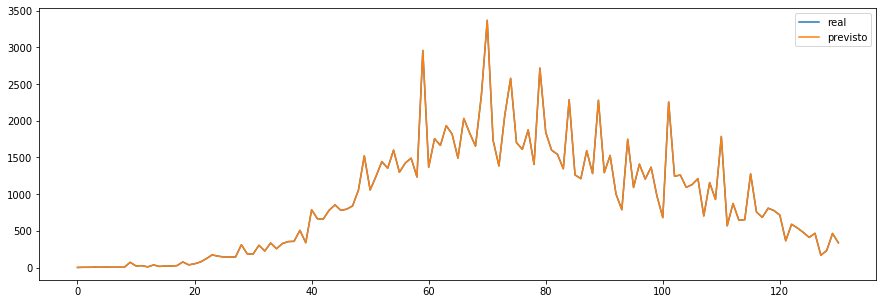

In [60]:
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor()
reg.fit(X, y)

plt.figure(figsize=(15, 5))
plt.plot(dados1.casos.values)
plt.plot(reg.predict(X))
plt.legend(['real', 'previsto'])

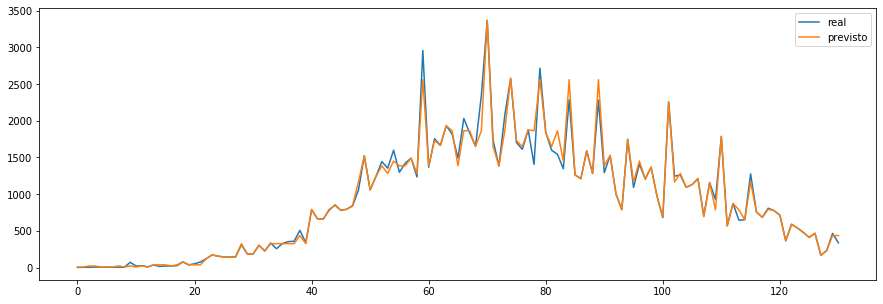

In [61]:
reg = DecisionTreeRegressor(max_depth=7) #Parametro para profundidade da árvore
reg.fit(X, y)

plt.figure(figsize=(15, 5))
plt.plot(dados1.casos.values)
plt.plot(reg.predict(X))
plt.legend(['real', 'previsto']) 

In [62]:
dados1['month'] = dados1.index.month
dados1.head()

,casos,naive,x1,ar_1,x_1,x_2,x_3,x_4,x_5,month
data,,,,,,,,,,
2020-02-21,1,9.0,9.0,186.179241,9.0,6.0,3.0,4.0,1.0,2
2020-02-22,3,1.0,1.0,179.769789,1.0,9.0,6.0,3.0,4.0,2
2020-02-23,3,3.0,3.0,181.372152,3.0,1.0,9.0,6.0,3.0,2
2020-02-24,6,3.0,3.0,181.372152,3.0,3.0,1.0,9.0,6.0,2
2020-02-25,4,6.0,6.0,183.775696,6.0,3.0,3.0,1.0,9.0,2


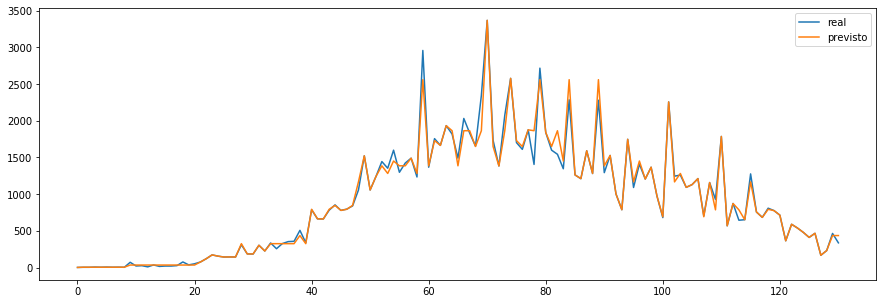

In [63]:
X = dados1.drop('casos', axis=1)
y = dados1.casos
reg = DecisionTreeRegressor(max_depth=7)
reg.fit(X, y)
plt.figure(figsize=(15, 5))
plt.plot(dados1.casos.values)
plt.plot(reg.predict(X))
plt.legend(['real', 'previsto'])

In [64]:
#Com validação
train_size = int(len(X) * 2/3)
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

reg = DecisionTreeRegressor(max_depth=7)
reg.fit(X_train, y_train)

((y_test - reg.predict(X_test)) ** 2).mean()

378088.3804040404

In [65]:
p = 3 #Número de lags a considerar
max_depth = 7

dados1 = dados[['casos']].copy()
for i in range(p):
    dados1[f'x_{i+1}'] = dados1.casos.shift(i + 1)
dados1.dropna(axis=0, inplace=True)
dados1['month'] = dados1.index.month

X = dados1.drop('casos', axis=1)
y = dados1.casos
train_size = int(len(X) * 2/3)
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

reg = DecisionTreeRegressor(max_depth=max_depth)
reg.fit(X_train, y_train)
((y_test - reg.predict(X_test)) ** 2).mean()

In [66]:
dados1.tail() 

,casos,x_1,x_2,x_3,month
data,,,,,
2020-06-26,466,410.0,479.0,538.0,6
2020-06-27,167,466.0,410.0,479.0,6
2020-06-28,231,167.0,466.0,410.0,6
2020-06-29,464,231.0,167.0,466.0,6
2020-06-30,336,464.0,231.0,167.0,6


In [67]:
periodo_futuro = dados1.index[-1] + np.timedelta64(1, 'D')
X_new = [list(np.flip(dados1.casos.tail(p).values, axis=0)) + [periodo_futuro.month]]
X_new

[[336, 464, 231, 7]]

In [68]:
reg.predict(X_new)

array([787.])

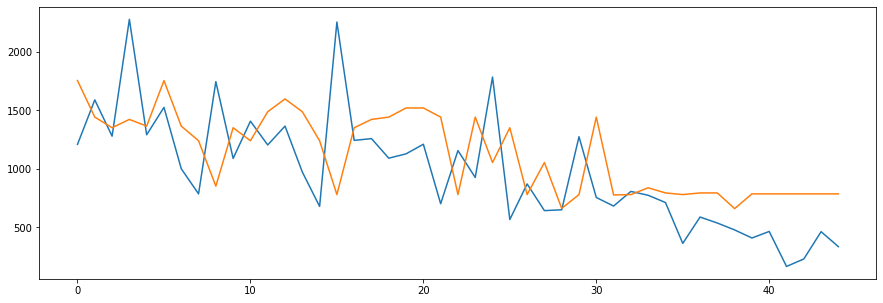

In [69]:
plt.figure(figsize=(15 ,5))
plt.plot(y_test.values)
plt.plot(reg.predict(X_test))